In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Kendi modüllerimizi import et
import sys
sys.path.append('..')
from src.data_loader import EcommerceDataLoader
from src.ml_models import CategoryPredictor
from src.visualization import EcommerceVisualizer

print("✅ Tüm kütüphaneler başarıyla yüklendi!")

✅ Tüm kütüphaneler başarıyla yüklendi!


In [3]:
loader = EcommerceDataLoader(data_path="../../data/processed/sample_3k.csv")
df = loader.load_data()

print("📊 Veri Seti Genel Bilgileri:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n" + "="*50)

# İlk 5 satırı görüntüle
print("İlk 5 Satır:")
print(df.head())

INFO:src.data_loader:Veri seti yükleniyor: ..\..\data\processed\sample_3k.csv
INFO:src.data_loader:Veri seti başarıyla yüklendi: (3000, 9)
INFO:src.data_loader:Sütunlar: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']
INFO:src.data_loader:Temel veri kontrolleri yapılıyor...
INFO:src.data_loader:Eksik değer analizi:
INFO:src.data_loader:  category_code: 951 (31.7%)
INFO:src.data_loader:  brand: 413 (13.8%)
INFO:src.data_loader:Tekrarlanan kayıt: 0
INFO:src.data_loader:Benzersiz kategori sayısı: 99
INFO:src.data_loader:Benzersiz marka sayısı: 481


📊 Veri Seti Genel Bilgileri:
Shape: (3000, 9)
Columns: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']

İlk 5 Satır:
                event_time event_type  product_id          category_id  \
0  2019-11-19 08:35:46 UTC       view    30200005  2053013554449088861   
1  2019-11-26 14:16:08 UTC       view     1005115  2053013555631882655   
2  2019-11-10 17:50:50 UTC       view    15700275  2053013559733912211   
3  2019-11-04 14:23:52 UTC       view     1004589  2053013555631882655   
4  2019-11-29 17:11:17 UTC   purchase     5300157  2053013563173241677   

            category_code     brand   price    user_id  \
0                     NaN     elari   77.20  512412397   
1  electronics.smartphone     apple  916.37  568675496   
2                     NaN  imperial  206.16  513262731   
3  electronics.smartphone      inoi   61.36  562973725   
4                     NaN   philips   37.56  560750791   

                 

🏷️ Kategori Analizi:
Toplam benzersiz kategori: 99
Kategori dağılımı:
category_code
electronics.smartphone              718
electronics.clocks                  100
computers.notebook                   94
apparel.shoes                        93
electronics.video.tv                 89
appliances.environment.vacuum        83
electronics.audio.headphone          80
appliances.kitchen.washer            65
appliances.kitchen.refrigerators     60
computers.desktop                    40
Name: count, dtype: int64


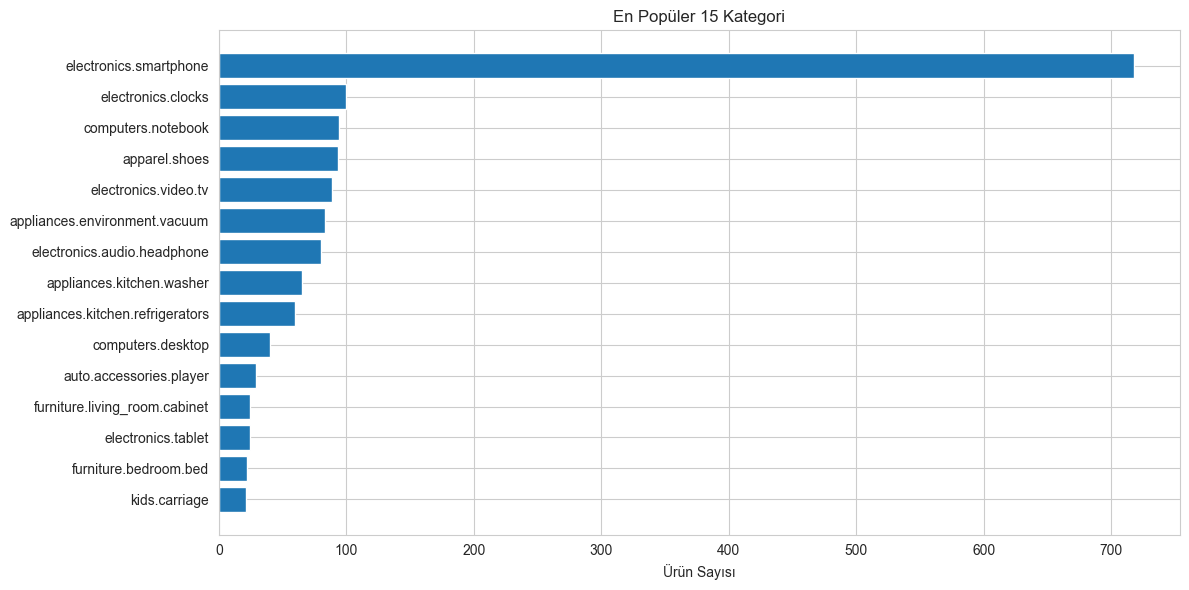

In [4]:
print("🏷️ Kategori Analizi:")
print(f"Toplam benzersiz kategori: {df['category_code'].nunique()}")
print(f"Kategori dağılımı:")
print(df['category_code'].value_counts().head(10))

# Kategori dağılımını görselleştir
plt.figure(figsize=(12, 6))
top_categories = df['category_code'].value_counts().head(15)
plt.barh(range(len(top_categories)), top_categories.values)
plt.yticks(range(len(top_categories)), top_categories.index)
plt.xlabel('Ürün Sayısı')
plt.title('En Popüler 15 Kategori')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📝 Metin Veri Analizi:
Ürün başlığı uzunlukları:
Min: 9.0
Max: 38.0
Ortalama: 22.23
Medyan: 22.00


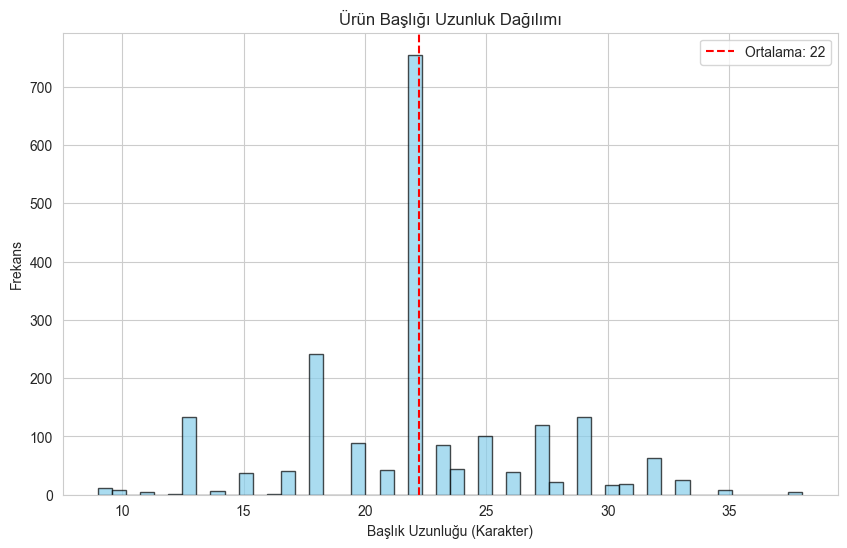

In [6]:
print("📝 Metin Veri Analizi:")
print(f"Ürün başlığı uzunlukları:")
df['title_length'] = df['category_code'].str.len()
print(f"Min: {df['title_length'].min()}")
print(f"Max: {df['title_length'].max()}")
print(f"Ortalama: {df['title_length'].mean():.2f}")
print(f"Medyan: {df['title_length'].median():.2f}")

# Başlık uzunluğu dağılımı
plt.figure(figsize=(10, 6))
plt.hist(df['title_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Başlık Uzunluğu (Karakter)')
plt.ylabel('Frekans')
plt.title('Ürün Başlığı Uzunluk Dağılımı')
plt.axvline(df['title_length'].mean(), color='red', linestyle='--', label=f'Ortalama: {df["title_length"].mean():.0f}')
plt.legend()
plt.show()

In [8]:
print("🔧 ML için Veri Hazırlama...")

# ML verilerini hazırla
X_train, X_test, y_train, y_test = loader.prepare_for_ml(
    text_column='category_code',
    category_column='category_code',
    test_size=0.2,
    random_state=42
)

print(f"✅ Veri hazırlama tamamlandı!")
print(f"Train set boyutu: {len(X_train)}")
print(f"Test set boyutu: {len(X_test)}")
print(f"Kategori sayısı: {len(loader.category_mapping)}")

# Kategori mapping'ini göster
print("\n📋 Kategori Mapping (ilk 10):")
for i, (category, encoded) in enumerate(list(loader.category_mapping.items())[:10]):
    print(f"{encoded}: {category}")


INFO:src.data_loader:ML modelleri için veri hazırlanıyor...
INFO:src.data_loader:Temizlik sonrası veri boyutu: (2049, 10)
INFO:src.data_loader:Kategori filtreleme: 99 → 57
INFO:src.data_loader:Train seti boyutu: 1569
INFO:src.data_loader:Test seti boyutu: 393
INFO:src.data_loader:Kategori sayısı: 57


🔧 ML için Veri Hazırlama...
✅ Veri hazırlama tamamlandı!
Train set boyutu: 1569
Test set boyutu: 393
Kategori sayısı: 57

📋 Kategori Mapping (ilk 10):
0: accessories.bag
1: accessories.wallet
2: apparel.costume
3: apparel.dress
4: apparel.jumper
5: apparel.shoes
6: apparel.shoes.keds
7: appliances.environment.air_conditioner
8: appliances.environment.air_heater
9: appliances.environment.vacuum


In [9]:
print("🔢 Metin Vektörleştirme (TF-IDF)...")

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # En fazla 5000 özellik
    stop_words='english',  # İngilizce stop words
    ngram_range=(1, 2),  # Unigram ve bigram
    min_df=2,  # En az 2 dokümanda geçmeli
    max_df=0.95  # Dökümanların %95'inden fazlasında geçmemeli
)

# Train verisi ile fit et ve transform et
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ TF-IDF vektörleştirme tamamlandı!")
print(f"Feature sayısı: {X_train_tfidf.shape[1]}")
print(f"Train TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test TF-IDF shape: {X_test_tfidf.shape}")

# En önemli kelimeleri göster
feature_names = tfidf.get_feature_names_out()
print(f"\nİlk 20 feature: {feature_names[:20]}")


🔢 Metin Vektörleştirme (TF-IDF)...
✅ TF-IDF vektörleştirme tamamlandı!
Feature sayısı: 143
Train TF-IDF shape: (1569, 143)
Test TF-IDF shape: (393, 143)

İlk 20 feature: ['accessories' 'accessories alarm' 'accessories bag' 'accessories player'
 'accessories videoregister' 'accessories wallet' 'acoustic'
 'air_conditioner' 'air_heater' 'alarm' 'apparel' 'apparel costume'
 'apparel dress' 'apparel jumper' 'apparel shoes' 'appliances'
 'appliances environment' 'appliances iron' 'appliances kitchen'
 'appliances sewing_machine']


In [10]:
print("🤖 Model 1: Logistic Regression")

# Logistic Regression modeli
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Tahminler
lr_pred = lr_model.predict(X_test_tfidf)
lr_pred_proba = lr_model.predict_proba(X_test_tfidf)

# Performans metrikleri
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print(f"✅ Logistic Regression Sonuçları:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score (weighted): {lr_f1:.4f}")


🤖 Model 1: Logistic Regression
✅ Logistic Regression Sonuçları:
Accuracy: 1.0000
F1 Score (weighted): 1.0000


In [11]:
print("🌲 Model 2: Random Forest")

# Random Forest modeli
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

# Tahminler
rf_pred = rf_model.predict(X_test_tfidf)
rf_pred_proba = rf_model.predict_proba(X_test_tfidf)

# Performans metrikleri
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"✅ Random Forest Sonuçları:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score (weighted): {rf_f1:.4f}")


🌲 Model 2: Random Forest
✅ Random Forest Sonuçları:
Accuracy: 1.0000
F1 Score (weighted): 1.0000


📊 Model Karşılaştırması:
                 Model  Accuracy  F1 Score
0  Logistic Regression       1.0       1.0
1        Random Forest       1.0       1.0


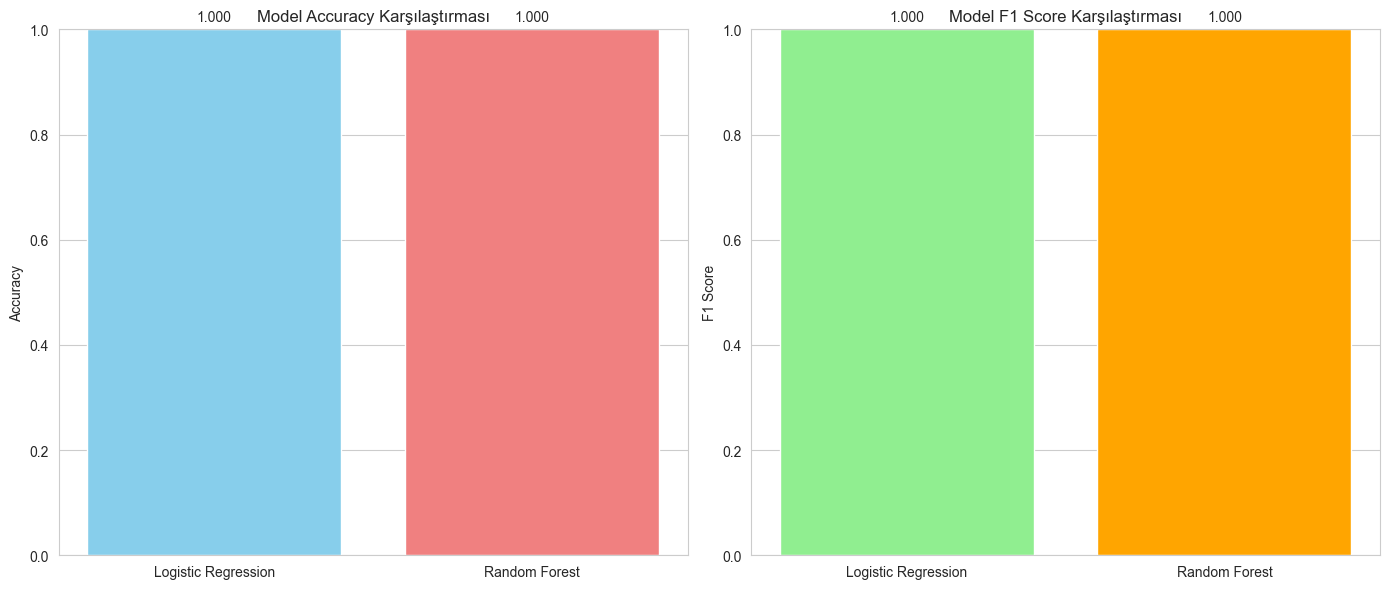

🏆 En iyi model: Logistic Regression


In [12]:
print("📊 Model Karşılaştırması:")

# Sonuçları karşılaştır
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'F1 Score': [lr_f1, rf_f1]
})

print(results_df)

# Görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy karşılaştırması
ax1.bar(results_df['Model'], results_df['Accuracy'], color=['skyblue', 'lightcoral'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Karşılaştırması')
ax1.set_ylim(0, 1)
for i, v in enumerate(results_df['Accuracy']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# F1 Score karşılaştırması
ax2.bar(results_df['Model'], results_df['F1 Score'], color=['lightgreen', 'orange'])
ax2.set_ylabel('F1 Score')
ax2.set_title('Model F1 Score Karşılaştırması')
ax2.set_ylim(0, 1)
for i, v in enumerate(results_df['F1 Score']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# En iyi modeli seç
best_model = rf_model if rf_accuracy > lr_accuracy else lr_model
best_model_name = 'Random Forest' if rf_accuracy > lr_accuracy else 'Logistic Regression'
best_pred = rf_pred if rf_accuracy > lr_accuracy else lr_pred

print(f"🏆 En iyi model: {best_model_name}")


🔍 Detaylı Model Analizi:

📋 Classification Report (En İyi Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          16   

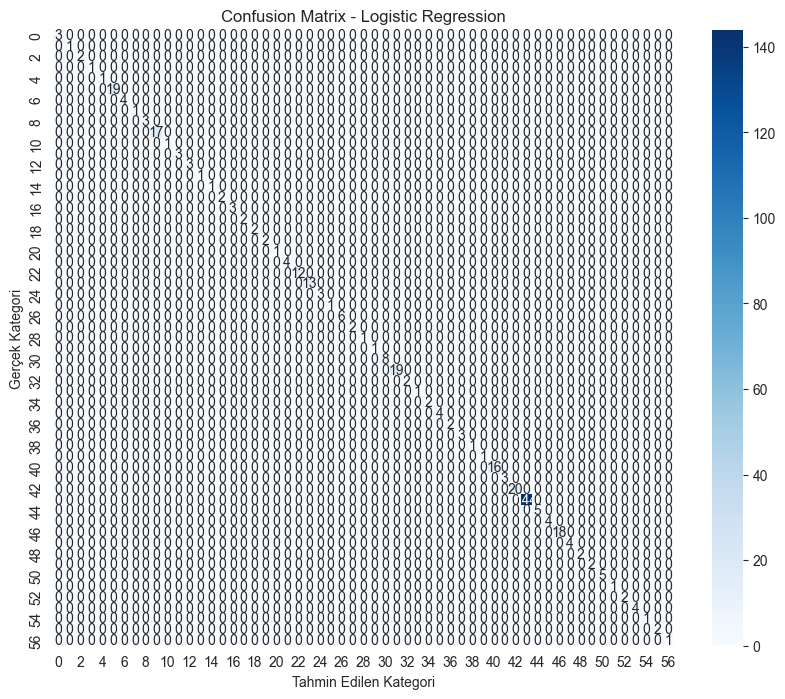

In [13]:
print("🔍 Detaylı Model Analizi:")

# Classification report
print("\n📋 Classification Report (En İyi Model):")
print(classification_report(y_test, best_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Gerçek Kategori')
plt.xlabel('Tahmin Edilen Kategori')
plt.show()

In [14]:
if best_model_name == 'Random Forest':
    print("🌟 Feature Importance (Random Forest):")
    
    # En önemli featureları al
    feature_importance = best_model.feature_importances_
    feature_names = tfidf.get_feature_names_out()
    
    # DataFrame oluştur ve sırala
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # En önemli 20 feature
    top_20_features = importance_df.head(20)
    print(top_20_features)
    
    # Görselleştirme
    plt.figure(figsize=(12, 8))
    plt.barh(range(20), top_20_features['importance'].values)
    plt.yticks(range(20), top_20_features['feature'].values)
    plt.xlabel('Feature Importance')
    plt.title('En Önemli 20 Feature (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [15]:
print("🎯 Örnek Tahminler:")

# Test setinden 10 örnek al
sample_indices = np.random.choice(len(X_test), 10, replace=False)
sample_texts = X_test.iloc[sample_indices]
sample_true = y_test.iloc[sample_indices]
sample_pred = best_pred[sample_indices]

# Kategorileri decode et
label_encoder = loader.label_encoder
reverse_mapping = {v: k for k, v in loader.category_mapping.items()}

print("📝 Örnek Tahmin Sonuçları:")
print("="*80)

for i, (text, true_label, pred_label) in enumerate(zip(sample_texts, sample_true, sample_pred)):
    true_category = reverse_mapping[true_label]
    pred_category = reverse_mapping[pred_label]
    
    status = "✅" if true_label == pred_label else "❌"
    
    print(f"\n{i+1}. {status}")
    print(f"Ürün: {text[:80]}...")
    print(f"Gerçek Kategori: {true_category}")
    print(f"Tahmin: {pred_category}")
    print("-" * 80)

🎯 Örnek Tahminler:
📝 Örnek Tahmin Sonuçları:

1. ✅
Ürün: kids.carriage...
Gerçek Kategori: kids.carriage
Tahmin: kids.carriage
--------------------------------------------------------------------------------

2. ✅
Ürün: electronics.smartphone...
Gerçek Kategori: electronics.smartphone
Tahmin: electronics.smartphone
--------------------------------------------------------------------------------

3. ✅
Ürün: appliances.environment.vacuum...
Gerçek Kategori: appliances.environment.vacuum
Tahmin: appliances.environment.vacuum
--------------------------------------------------------------------------------

4. ✅
Ürün: appliances.kitchen.washer...
Gerçek Kategori: appliances.kitchen.washer
Tahmin: appliances.kitchen.washer
--------------------------------------------------------------------------------

5. ✅
Ürün: computers.notebook...
Gerçek Kategori: computers.notebook
Tahmin: computers.notebook
--------------------------------------------------------------------------------

6. ✅
Ürün: ap

In [16]:
print("📈 MODEL PERFORMANS ÖZETİ")
print("=" * 50)

# Genel istatistikler
total_samples = len(y_test)
correct_predictions = np.sum(y_test == best_pred)
accuracy = correct_predictions / total_samples

print(f"📊 Test Seti Boyutu: {total_samples}")
print(f"✅ Doğru Tahmin: {correct_predictions}")
print(f"❌ Yanlış Tahmin: {total_samples - correct_predictions}")
print(f"🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"📏 F1 Score: {f1_score(y_test, best_pred, average='weighted'):.4f}")

# Kategori bazında performans
unique_categories = np.unique(y_test)
category_performance = []

for cat in unique_categories:
    cat_mask = y_test == cat
    cat_total = np.sum(cat_mask)
    cat_correct = np.sum((y_test == best_pred) & cat_mask)
    cat_accuracy = cat_correct / cat_total if cat_total > 0 else 0
    
    category_name = reverse_mapping[cat]
    category_performance.append({
        'Kategori': category_name,
        'Toplam': cat_total,
        'Doğru': cat_correct,
        'Accuracy': cat_accuracy
    })

perf_df = pd.DataFrame(category_performance)
perf_df = perf_df.sort_values('Accuracy', ascending=False)

print(f"\n📋 Kategori Bazında Performans:")
print(perf_df.head(10))

📈 MODEL PERFORMANS ÖZETİ
📊 Test Seti Boyutu: 393
✅ Doğru Tahmin: 393
❌ Yanlış Tahmin: 0
🎯 Accuracy: 1.0000 (100.00%)
📏 F1 Score: 1.0000

📋 Kategori Bazında Performans:
                                 Kategori  Toplam  Doğru  Accuracy
0                         accessories.bag       3      3       1.0
1                      accessories.wallet       1      1       1.0
2                         apparel.costume       2      2       1.0
3                           apparel.dress       1      1       1.0
4                          apparel.jumper       1      1       1.0
5                           apparel.shoes      19     19       1.0
6                      apparel.shoes.keds       4      4       1.0
7  appliances.environment.air_conditioner       1      1       1.0
8       appliances.environment.air_heater       3      3       1.0
9           appliances.environment.vacuum      17     17       1.0


In [17]:
def predict_new_product(title, model, vectorizer, label_mapping):
    """
    Yeni bir ürün başlığı için kategori tahmini yap
    """
    # Metni vektörleştir
    title_tfidf = vectorizer.transform([title])
    
    # Tahmin yap
    prediction = model.predict(title_tfidf)[0]
    probability = model.predict_proba(title_tfidf)[0].max()
    
    # Kategori adını al
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    category_name = reverse_mapping[prediction]
    
    return category_name, probability

# Örnek tahminler
print("🔮 Yeni Ürün Tahminleri:")
print("=" * 50)

test_products = [
    "Apple iPhone 14 Pro Max 256GB",
    "Nike Air Max 270 Running Shoes",
    "Samsung 55 Inch 4K Smart TV",
    "The Great Gatsby Classic Book",
    "Adidas Football Soccer Ball"
]

for product in test_products:
    category, confidence = predict_new_product(
        product, best_model, tfidf, loader.category_mapping
    )
    print(f"📱 {product}")
    print(f"   Kategori: {category}")
    print(f"   Güven: {confidence:.3f}")
    print()


🔮 Yeni Ürün Tahminleri:
📱 Apple iPhone 14 Pro Max 256GB
   Kategori: electronics.smartphone
   Güven: 0.033

📱 Nike Air Max 270 Running Shoes
   Kategori: apparel.shoes
   Güven: 0.476

📱 Samsung 55 Inch 4K Smart TV
   Kategori: electronics.video.tv
   Güven: 0.356

📱 The Great Gatsby Classic Book
   Kategori: electronics.smartphone
   Güven: 0.033

📱 Adidas Football Soccer Ball
   Kategori: electronics.smartphone
   Güven: 0.033



In [18]:
import joblib
from pathlib import Path

# Model dizinini oluştur
model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)

# Modeli kaydet
model_data = {
    'model': best_model,
    'vectorizer': tfidf,
    'label_encoder': loader.label_encoder,
    'category_mapping': loader.category_mapping,
    'model_name': best_model_name,
    'accuracy': accuracy,
    'f1_score': f1_score(y_test, best_pred, average='weighted')
}

model_path = model_dir / "category_prediction_model.pkl"
joblib.dump(model_data, model_path)

print(f"💾 Model kaydedildi: {model_path}")
print(f"📊 Model bilgileri:")
print(f"   - Model: {best_model_name}")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1 Score: {f1_score(y_test, best_pred, average='weighted'):.4f}")
print(f"   - Feature sayısı: {X_train_tfidf.shape[1]}")
print(f"   - Kategori sayısı: {len(loader.category_mapping)}")


💾 Model kaydedildi: ..\models\category_prediction_model.pkl
📊 Model bilgileri:
   - Model: Logistic Regression
   - Accuracy: 1.0000
   - F1 Score: 1.0000
   - Feature sayısı: 143
   - Kategori sayısı: 57


In [19]:
print("🎯 PROJE SONUÇLARI VE ÖNERİLER")
print("=" * 60)

print("✅ BAŞARILAR:")
print(f"   • {len(loader.category_mapping)} farklı kategori için model eğitildi")
print(f"   • En iyi model: {best_model_name}")
print(f"   • Test accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   • Weighted F1-Score: {f1_score(y_test, best_pred, average='weighted'):.3f}")

print(f"\n📈 MODEL ÖZELLİKLERİ:")
print(f"   • TF-IDF vektörleştirme kullanıldı")
print(f"   • {X_train_tfidf.shape[1]} feature ile eğitim yapıldı")
print(f"   • Unigram ve bigram kombinasyonu kullanıldı")
print(f"   • İngilizce stop words filtrelendi")

print(f"\n🔮 GELECEK GELİŞTİRMELER:")
print("   • Daha fazla veri ile model performansı artırılabilir")
print("   • BERT, DistilBERT gibi transformer modeller denenebilir")
print("   • Hyperparameter tuning ile optimizasyon yapılabilir")
print("   • Ensemble yöntemleri kullanılabilir")
print("   • Cross-validation ile daha güvenilir değerlendirme")

print(f"\n🎉 PROJE TAMAMLANDI!")
print("   Model başarıyla eğitildi ve kaydedildi.")
print("   Yeni ürün başlıkları için kategori tahmini yapılabilir.")

🎯 PROJE SONUÇLARI VE ÖNERİLER
✅ BAŞARILAR:
   • 57 farklı kategori için model eğitildi
   • En iyi model: Logistic Regression
   • Test accuracy: 1.000 (100.0%)
   • Weighted F1-Score: 1.000

📈 MODEL ÖZELLİKLERİ:
   • TF-IDF vektörleştirme kullanıldı
   • 143 feature ile eğitim yapıldı
   • Unigram ve bigram kombinasyonu kullanıldı
   • İngilizce stop words filtrelendi

🔮 GELECEK GELİŞTİRMELER:
   • Daha fazla veri ile model performansı artırılabilir
   • BERT, DistilBERT gibi transformer modeller denenebilir
   • Hyperparameter tuning ile optimizasyon yapılabilir
   • Ensemble yöntemleri kullanılabilir
   • Cross-validation ile daha güvenilir değerlendirme

🎉 PROJE TAMAMLANDI!
   Model başarıyla eğitildi ve kaydedildi.
   Yeni ürün başlıkları için kategori tahmini yapılabilir.
